In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq.job import job_monitor
provider = IBMQ.load_account()

/tmp/ipykernel_122/1933496013.py:11: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


# グローバーのアルゴリズムで簡単なパズルを解く2
パズルにアルゴリズムを適用するコツを掴んだので、ペンシルパズルとして有名な題材を使って解くことにしました。<br>
「ライトアップ」や「美術館」と言われているパズルで、説明が難しいので以下にリンクを貼っておきます。<br>
https://www.nikoli.co.jp/ja/puzzles/akari/<br>
今回解くパズルは次のような4×4の盤面で構成されています。

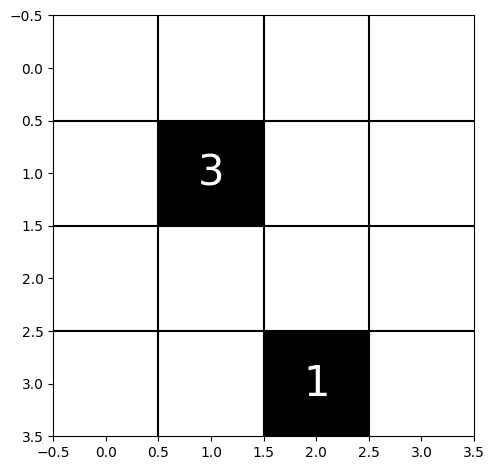

In [2]:
board = np.array([
    [0, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1, 0]
])

fig, ax = plt.subplots()

# グレーのカラーマップを使用して1の部分をグレーにする
ax.imshow(board, cmap='Greys', interpolation='none')


ax.text(1, 1, "3", color='white', ha='center', va='center', fontsize=30)

ax.text(2, 3, "1", color='white', ha='center', va='center', fontsize=30)

for i in range(board.shape[0] - 1):
    ax.axhline(y=i + 0.5, color='black')
for j in range(board.shape[1] - 1):
    ax.axvline(x=j + 0.5, color='black')

plt.tight_layout()
plt.show()


# 実装方法

パズル1と異なり、正解の判定をマスごとにすると難しくなります。マス単位だと明かりが重複しても良いからです。
列単位に注目すると、各列に照明はただ一つしか存在できないため、Multi-controlled Zゲートで容易に判定できます。<br>
一方、入力状態はマスごとになるので、記憶用ビットを用意することにしました。<br>
これで量子ビットの割り振りができたのですが、ビット数を減らしたいのでちょっと工夫します。<br>
3が書いてあるマスからナナメ1マスの場所は照明を置けないので、入力から省きます。<br>
その上で量子ビットを割り振ると以下のようになります。

In [10]:
board = [['×', 'A', '×', '0'],
         ['A', ' ', 'A', '1'],
         ['×', 'A', '×', '2'],
         ['3', 'B', ' ', 'B']]

print('量子ビットの割り振り:')

for index, row in enumerate(board):
    print('|', end=' ')
    for panel in row:
        print(panel, end=' | ')
    print(f' ←{index + 7}')

print('  ↑   ↑   ↑   ↑')
print('  7   8   9   10')
print('A = 4,5')
print('B = 6')
board = [[' ', '3', ' ', ' '],
         ['0', ' ', '2', ' '],
         [' ', '1', ' ', ' '],
         [' ', '0', ' ', '1']]

print('A,Bの値の割り振り:')

for row in board:
    print('|', end=' ')
    for panel in row:
        print(panel, end=' | ')
    print()

量子ビットの割り振り:
| × | A | × | 0 |  ←7
| A |   | A | 1 |  ←8
| × | A | × | 2 |  ←9
| 3 | B |   | B |  ←10
  ↑   ↑   ↑   ↑
  7   8   9   10
A = 4,5
B = 6
A,Bの値の割り振り:
|   | 3 |   |   | 
| 0 |   | 2 |   | 
|   | 1 |   |   | 
|   | 0 |   | 1 | 


入力状態が6ビットまで減らせてしまったので、正解判定に8ビット（縦横8列）使うのはもったいない気がします。<br>
縦4列を7,8,9,10で判定→判定結果を4に格納→横4列と縦の結果を合わせて7,8,9,10,11で判定<br>
という判定方法にしました。<br>
また、わざわざ入力情報を別の量子ビットに移さなくても良いことに気づいたので、判定を0〜4ではなく6〜10で行うことにします。<br>
振幅増幅の部分だけ関数を定義しておきます。

In [3]:
#正解の振幅を増幅する回路
def make_diffuser(qc, n):
    qc.barrier()
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mct(list(range(n-1)),n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    


ここで、一つ重要な問題を忘れていることに気づきました。今のままだと各ビットは偶奇の判定しかできないため、「各列に1つだけ」という条件を表せていないことです。今回の盤面だと、縦の(0から数えて)3列目に最大4つ照明が置けるので、単に制御ノットを置くだけでは条件をうまく作れません。<br>
とりあえずは、以下のように組んでいます。

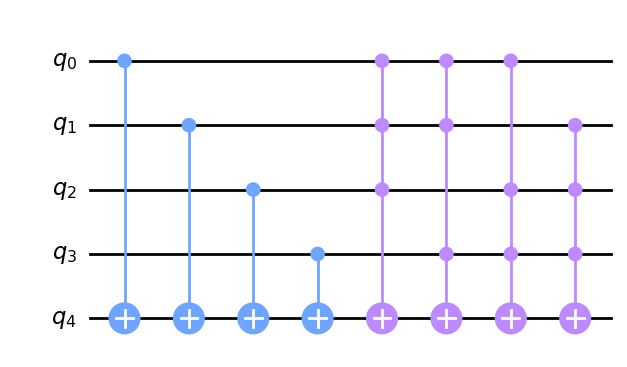

In [24]:
qc = QuantumCircuit(5, 0) #0から３が入力ビット、4が出力ビット
qc.cx(range(4),4)
qc.mct([0,1,2],4)
qc.mct([0,1,3],4)
qc.mct([0,2,3],4)
qc.mct([1,2,3],4)
qc.draw(output='mpl')

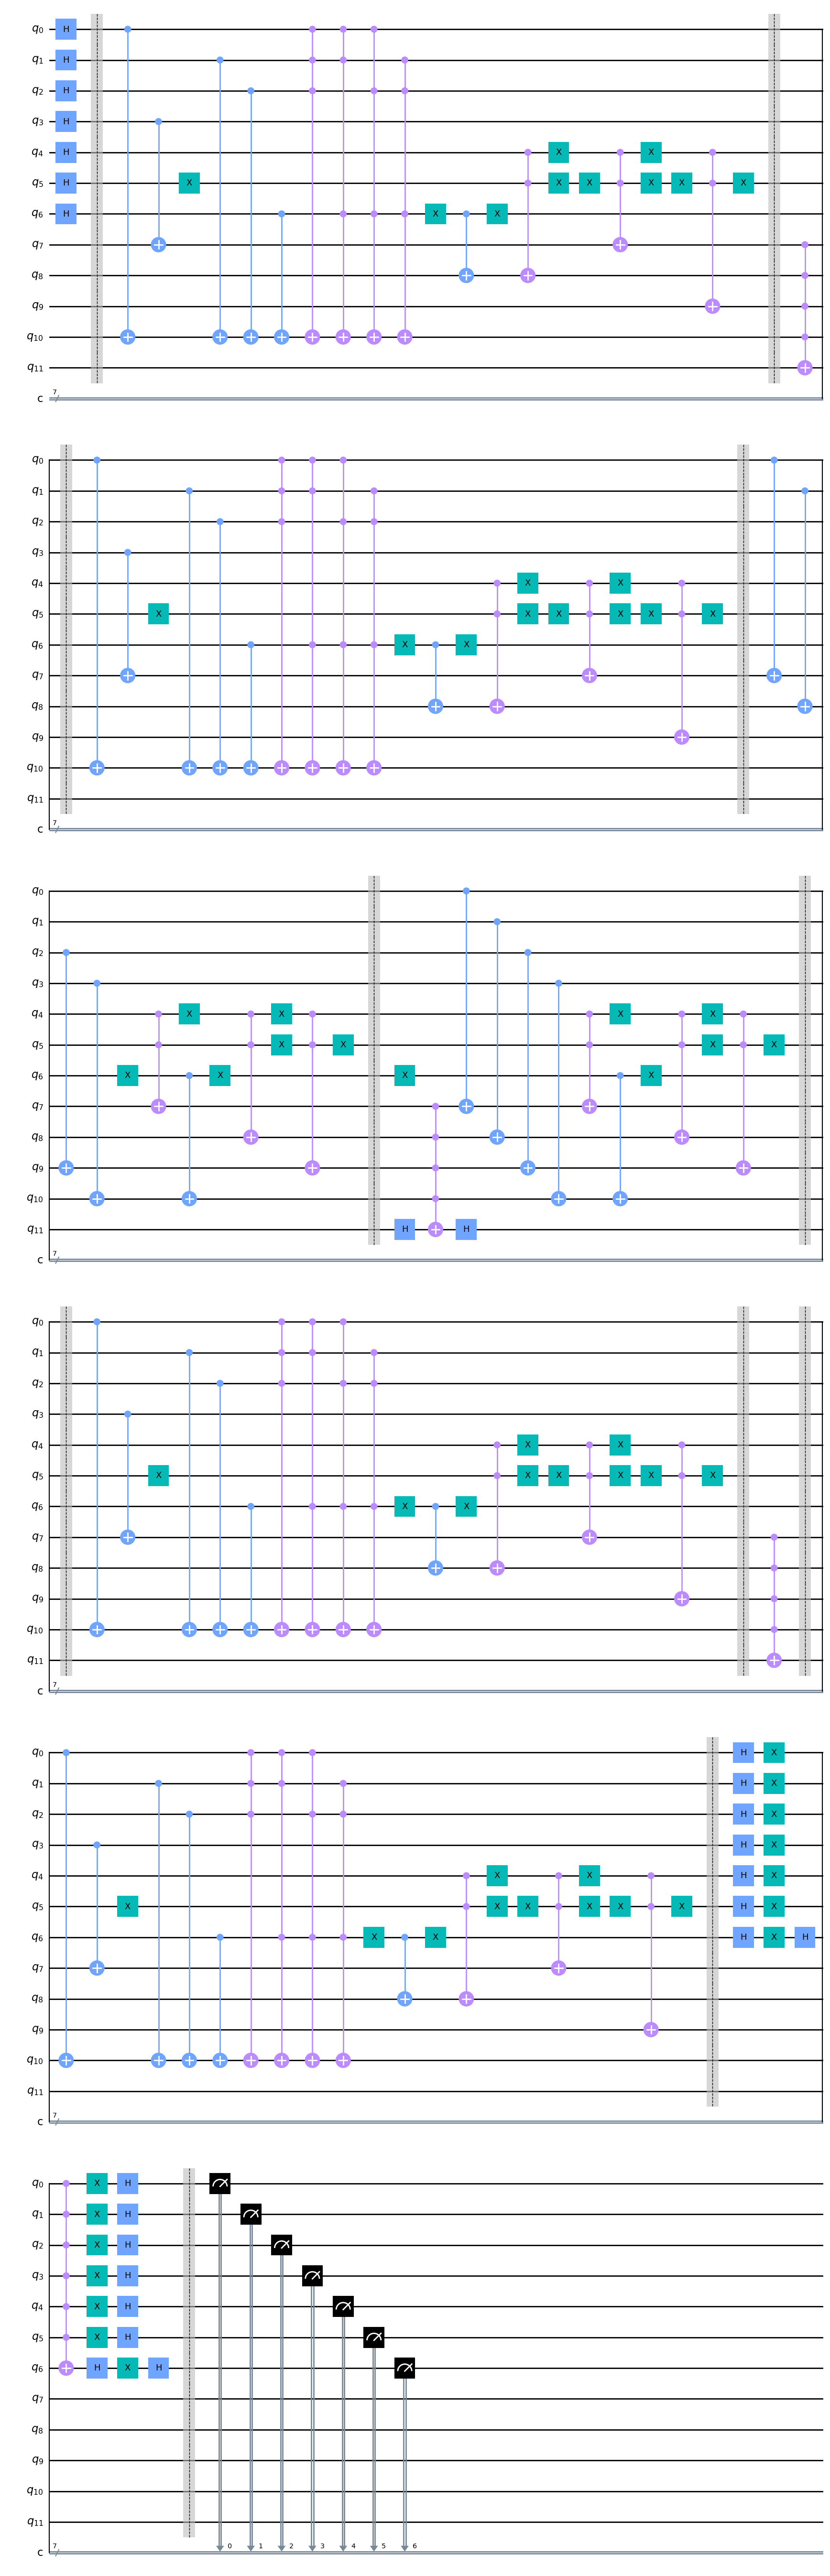

In [33]:
#量子ビット数と古典ビット数
n = 7 #入力に対応している量子ビット
a = 5 #出力に対応している量子ビット
q = n + a #量子ビット数
c = n #古典ビット数



#最初に全ての状態を同じ確率で重ね合わせる
circ_init = QuantumCircuit(q, c)
circ_init.h(range(n))



#オラクル回路
oracle = QuantumCircuit(q, c)
oracle.barrier()

#まず縦列のみ考える。以下、コメントアウトは処理するマスの番号
#0,1,2,6の処理
oracle.cx(range(3),10)
oracle.cx(6,10)
oracle.mct([0,1,2],10)
oracle.mct([0,1,6],10)
oracle.mct([0,2,6],10)
oracle.mct([1,2,6],10)

#6の処理の残り
oracle.x(6)
oracle.cx(6,8)
oracle.x(6)

#3の処理
oracle.cx(3,7)

#4,5の処理
#11 = 3 のとき: なし
#01 = 1のとき:
oracle.x(5)
oracle.ccx(4,5,8)
oracle.x(5)

#00 = 0のとき:
oracle.x(4)
oracle.x(5)
oracle.ccx(4,5,7)
oracle.x(5)
oracle.x(4)

#10 = 2のとき:
oracle.x(5)
oracle.ccx(4,5,9)
oracle.x(5)

#縦が1111になっているか判定、なっていればビット11を1にする
oracle.barrier()
oracle.mct([7,8,9,10],11)

#逆操作をかける
oracle.barrier()
oracle.cx(range(3),10)
oracle.cx(6,10)
oracle.mct([0,1,2],10)
oracle.mct([0,1,6],10)
oracle.mct([0,2,6],10)
oracle.mct([1,2,6],10)
oracle.x(6)
oracle.cx(6,8)
oracle.x(6)
oracle.cx(3,7)
oracle.x(5)
oracle.ccx(4,5,8)
oracle.x(5)
oracle.x(4)
oracle.x(5)
oracle.ccx(4,5,7)
oracle.x(5)
oracle.x(4)
oracle.x(5)
oracle.ccx(4,5,9)
oracle.x(5)

oracle.barrier()


#次に横列のみ考える。以下、コメントアウトは処理するマスの番号
#0〜3の処理
for i in range(0,4):
    oracle.cx(i, i+7)
    
#4,5の処理
#00 = 0のとき:なし
#11 = 3のとき:
oracle.ccx(4,5,7)

#10 = 2のとき:
oracle.x(4)
oracle.ccx(4,5,8)
oracle.x(4)

#01 = 1のとき:
oracle.x(5)
oracle.ccx(4,5,9)
oracle.x(5)

#6の処理
oracle.x(6)
oracle.cx(6,10)
oracle.x(6)

#横が1111になっている + 縦が条件を満たしているか判定、なっていれば位相を反転する
oracle.barrier()
oracle.h(11)
oracle.mct([7,8,9,10],11)
oracle.h(11)

#逆操作をかける
for i in range(0,4):
    oracle.cx(i, i+7)
oracle.ccx(4,5,7)
oracle.x(4)
oracle.ccx(4,5,8)
oracle.x(4)
oracle.x(5)
oracle.ccx(4,5,9)
oracle.x(5)
oracle.x(6)
oracle.cx(6,10)
oracle.x(6)

oracle.barrier()

#ビット11の値を元に戻すために、もう一度縦の操作を行う
oracle.barrier()
oracle.cx(range(3),10)
oracle.cx(6,10)
oracle.mct([0,1,2],10)
oracle.mct([0,1,6],10)
oracle.mct([0,2,6],10)
oracle.mct([1,2,6],10)
oracle.x(6)
oracle.cx(6,8)
oracle.x(6)
oracle.cx(3,7)
oracle.x(5)
oracle.ccx(4,5,8)
oracle.x(5)
oracle.x(4)
oracle.x(5)
oracle.ccx(4,5,7)
oracle.x(5)
oracle.x(4)
oracle.x(5)
oracle.ccx(4,5,9)
oracle.x(5)
oracle.barrier()
oracle.mct([7,8,9,10],11)
oracle.barrier()
oracle.cx(range(3),10)
oracle.cx(6,10)
oracle.mct([0,1,2],10)
oracle.mct([0,1,6],10)
oracle.mct([0,2,6],10)
oracle.mct([1,2,6],10)
oracle.x(6)
oracle.cx(6,8)
oracle.x(6)
oracle.cx(3,7)
oracle.x(5)
oracle.ccx(4,5,8)
oracle.x(5)
oracle.x(4)
oracle.x(5)
oracle.ccx(4,5,7)
oracle.x(5)
oracle.x(4)
oracle.x(5)
oracle.ccx(4,5,9)
oracle.x(5)



#位相回路
diffuser = QuantumCircuit(q, c)
make_diffuser(diffuser, n)


#繋げてグローバーの繰り返し回路を作る
grover = oracle.compose(diffuser)

#測定回路
meas = QuantumCircuit(q, c)
meas.barrier()
meas.measure(range(n),range(n))


#n回繰り返した回路を出力する
def repeated_circuit(n):
    circ = circ_init
    for i in range(0,n):
        circ = circ.compose(grover)
    circ = circ.compose(meas)
    return circ


#回路を表示
repeated_circuit(1).draw(output='mpl')

シミュレーターで試します。繰り返し回数nは、<br>
解が1個の場合、n = 17<br>
解が2個の場合、n = 8<br>
解が3個の場合、n = 5 ...<br>
のとき確率が大きくなります。シミュレータの場合、nがそれほど大きくなくても差が目に見えて分かりますね。<br>
結果の表示は、単純に値が大きいものからソートして、上位10組だけ表示するようにしました。

In [34]:
#シミュレータで試す
simulator = Aer.get_backend('qasm_simulator')

shots = 8192 
n = 8 #繰り返し回数

job_sim = execute(repeated_circuit(n), backend=simulator, shots=shots)

#実行結果からカウントのみ取得
counts_sim = job_sim.result().get_counts(repeated_circuit(n))

#得られた辞書データを大きい順にソート
sorted_counts_sim = sorted(counts_sim.items(), key=lambda x: x[1], reverse=True)[:10]
print(sorted_counts_sim)

[('0010000', 84), ('1111101', 83), ('0111011', 79), ('1110010', 79), ('1100001', 78), ('0110101', 78), ('1001010', 77), ('0001001', 77), ('0001011', 76), ('1011001', 76)]


In [26]:
#プロバイダーの設定
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider(instance='ibm-q-utokyo/internal/adv-sci-1a-2023s')

back=provider.backends()

for i in back:
    print(i)

<IBMBackend('ibmq_kolkata')>
<IBMBackend('simulator_stabilizer')>
<IBMBackend('ibm_sherbrooke')>
<IBMBackend('ibmq_guadalupe')>
<IBMBackend('ibmq_manila')>
<IBMBackend('ibmq_quito')>
<IBMBackend('simulator_mps')>
<IBMBackend('ibm_kawasaki')>
<IBMBackend('ibm_lagos')>
<IBMBackend('ibm_nairobi')>
<IBMBackend('ibm_hanoi')>
<IBMBackend('ibmq_lima')>
<IBMBackend('ibmq_mumbai')>
<IBMBackend('simulator_statevector')>
<IBMBackend('ibm_algiers')>
<IBMBackend('ibm_auckland')>
<IBMBackend('ibm_brisbane')>
<IBMBackend('ibm_cairo')>
<IBMBackend('ibmq_qasm_simulator')>
<IBMBackend('simulator_extended_stabilizer')>
<IBMBackend('ibm_nazca')>
<IBMBackend('ibm_perth')>
<IBMBackend('ibmq_belem')>
<IBMBackend('ibmq_jakarta')>


In [32]:
#デバイスを取得
device=back[7]

shots = 2048
n = 6

#回路を実行、測定結果を取得して配列に
job_exp = execute(repeated_circuit(n), backend = device, shots=shots)
job_monitor(job_exp)


Traceback (most recent call last):
  Cell In[32], line 8
    job_exp = execute(repeated_circuit(n), backend = device, shots=shots)
  File /opt/conda/lib/python3.10/site-packages/qiskit/utils/deprecation.py:182 in wrapper
    return func(*args, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/qiskit/utils/deprecation.py:182 in wrapper
    return func(*args, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/qiskit/execute_function.py:302 in execute
    experiments = transpile(
  File /opt/conda/lib/python3.10/site-packages/qiskit/compiler/transpiler.py:358 in transpile
    _check_circuits_coupling_map(circuits, cmap_conf, backend)
  File /opt/conda/lib/python3.10/site-packages/qiskit/compiler/transpiler.py:417 in _check_circuits_coupling_map
    raise TranspilerError(
TranspilerError: 'Number of qubits (18) in circuit-129 is greater than maximum (7) in the coupling_map'

Use %tb to get the full traceback.


In [ ]:
job_monitor(job_exp)

In [ ]:
counts_exp = job_exp.result().get_counts(repeated_circuit(i))

#得られた辞書データを大きい順にソート
sorted_counts_exp = sorted(counts_exp.items(), key=lambda x: x[1], reverse=True)[:10]
print(sorted_counts_exp)